# Project: Spatial Data  Interpolation
## NDE vs MCMC
* Herman Franclin Tesso Tassang
* Carlin Foka

In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 7.4 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import pandas as pd
from jax import random
# dsitributions
import numpyro
import numpyro.distributions as dist

import time

from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Since we are using jax, we will need a random key:
rng = jax.random.PRNGKey(42)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#####################################

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import pi, log
from torch.utils import data
import numpy as np
from torch import tensor
from torch.distributions import Normal
import matplotlib as mpl
from torch.utils.data import Dataset, DataLoader
_ = torch.manual_seed(0)

In [185]:
#@title measures
num=400
# Define the mean vector
mean = np.array( np.random.uniform(0, 4, num))

# Define the diagonal covariance matrix (variances along the diagonal)
covariance_matrix = np.diag(np.random.uniform(0,1.5, num))

# Number of samples to generate
num_samples =1

# Generate samples from the multivariate Gaussian distribution
samples = np.random.multivariate_normal(mean, covariance_matrix, num_samples)
samples=samples[0]

In [186]:
samples.shape

(400,)

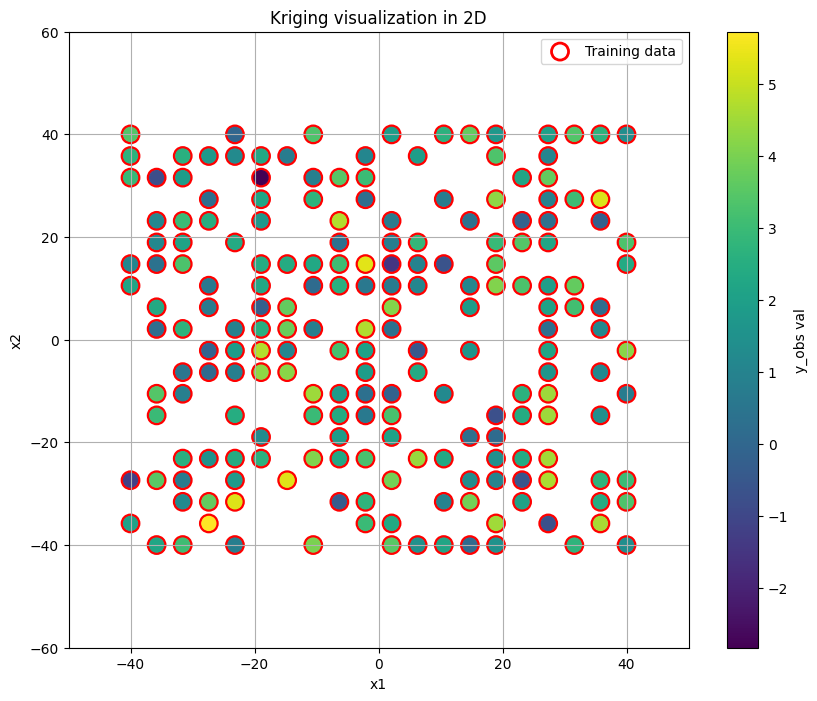

In [188]:
#@title Simulate and visualize spatial data (2D)
N=int(np.sqrt(num))
## location ( 2d)
a=np.linspace(-40,40,N)
b=np.linspace(-40,40,N)
A,B=np.meshgrid(a,b)

# true measurenp.delete(x, exclude)
Z =samples.reshape(A.shape)

# observed measure (missing  val )
noise=np.random.normal(0, 0.1, size=(N, N))
Y = Z + noise
Y2=np.copy(Y.ravel())
random_index=np.random.choice(len(Z.ravel()), size=int(num/2), replace=False)
Y1=Y.ravel()
Y1[random_index]=np.nan

Y=Y1.reshape(N,N)
## extract corresponding location

x=np.delete(A.ravel(),random_index)
y=np.delete(B.ravel(),random_index)
y_obs=np.delete(Y.ravel(),random_index)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(x, y, s=150, c='none', edgecolor='red', linewidth=2, label='Training data')
plt.scatter(x, y, s=100, c=y_obs, cmap='viridis')
plt.title('Kriging visualization in 2D')
plt.colorbar(label='y_obs val')
plt.legend()
plt.grid(True)
plt.xlim(-50,50)
plt.ylim(-60,60)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

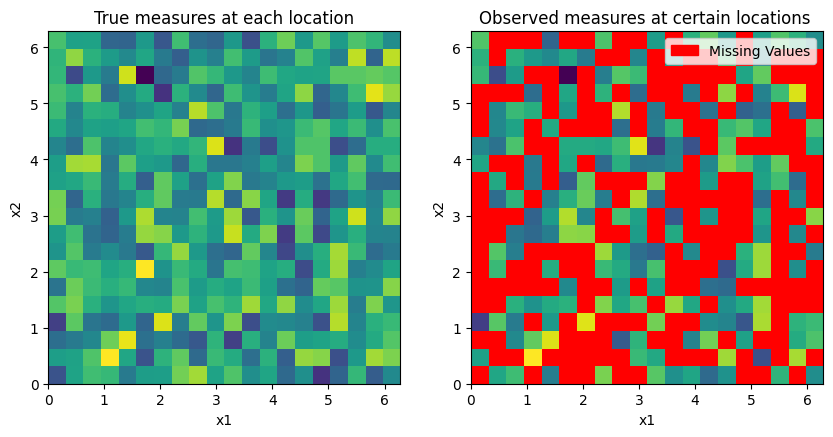

In [189]:
#@title Heatmap representation

cmap = plt.cm.viridis
cmap.set_bad(color='red')

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

im1 = axes[0].imshow(Z, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
axes[0].set_title('True measures at each location')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

im2 = axes[1].imshow(Y, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap=cmap)
axes[1].set_title('Observed measures at certain locations ')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

legend_handles = [mpatches.Patch(color='red', label='Missing Values')]
axes[1].legend(handles=legend_handles)

In [190]:
location=torch.tensor(np.column_stack([x,y]))
measure=torch.tensor(y_obs)
print(location.shape)
print(measure.shape)

torch.Size([200, 2])
torch.Size([200])


# NDE approach for Interpolation

we learn a conditional density base on observations , provide (predict) a distribution of unobserved measure at a given location of interest.


* model: mixture of Gaussian densities
* approach : Neural Network to learn the parameters of the Model.
* Input : location as 2D-cordinate $(x_1,x_2)$
* output : conditional density $P(. \mid (x_1,x_2))$ representing distribution of measures at a conditioning location
* data : observed measure at providing location




In [22]:
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [68]:
#@title Build the Mixture of Gaussian model
"""
Implementation of models based on
C. M. Bishop, "Mixture Density Networks", NCRG Report (1994)

Taken from http://github.com/conormdurkan/lfi. See there for copyright.
"""
from typing import Optional, Tuple

import numpy as np
import torch
from torch import nn, Tensor
from torch.nn import functional as F

from nflows.utils import torchutils


# This implementation based on Conor M. Durkan's et al. lfi package (2020).
# https://github.com/conormdurkan/lfi/blob/master/src/nn_/nde/mdn.py
class MultivariateGaussianMDN(nn.Module):
    """
    Conditional density mixture of multivariate Gaussians, after Bishop [1].

    A multivariate Gaussian mixture with full (rather than diagonal) covariances

    [1] Bishop, C.: 'Mixture Density Networks', Neural Computing Research Group Report
    1994 https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf
    """

    def __init__(
        self,
        features: int,
        context_features: int,
        hidden_features: int,
        hidden_net: nn.Module,
        num_components: int,
        custom_initialization=False,
        embedding_net=None,
    ):
        """Mixture of multivariate Gaussians with full diagonal.

        Args:
            features: Dimension of output density.
            context_features: Dimension of inputs.
            hidden_features: Dimension of final layer of `hidden_net`.
            hidden_net: A Module which outputs final hidden representation before
                paramterization layers (i.e logits, means, and log precisions).
            num_components: Number of mixture components.
            custom_initialization: XXX
        """

        super().__init__()

        self._features = features
        self._context_features = context_features
        self._hidden_features = hidden_features
        self._num_components = num_components

        self._num_upper_params = (features * (features - 1)) // 2

        self._row_ix, self._column_ix = np.triu_indices(features, k=1)
        self._diag_ix = range(features)

        # Modules
        self._hidden_net = hidden_net

        self._logits_layer = nn.Linear(hidden_features, num_components)

        self._means_layer = nn.Linear(hidden_features, num_components * features)

        self._unconstrained_diagonal_layer = nn.Linear(
            hidden_features, num_components * features
        )
        self._upper_layer = nn.Linear(
            hidden_features, num_components * self._num_upper_params
        )

        # XXX docstring text
        # embedding_net: NOT IMPLEMENTED
        #         A `nn.Module` which has trainable parameters to encode the
        #         context (conditioning). It is trained jointly with the MDN.
        if embedding_net is not None:
            raise NotImplementedError

        # Constant for numerical stability.
        self._epsilon = 1e-4

        # Initialize mixture coefficients and precision factors sensibly.
        if custom_initialization:
            self._initialize()

    def get_mixture_components(
        self, context: Tensor
    ) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
        """Return logits, means, precisions and two additional useful quantities.

        Args:
            context: Input to the MDN, leading dimension is batch dimension.

        Returns:
            A tuple with logits (num_components), means (num_components x output_dim),
            precisions (num_components, output_dim, output_dim), sum log diag of
            precision factors (1), precision factors (upper triangular precision factor
            A such that SIGMA^-1 = A^T A.) All batched.
        """

        h = self._hidden_net(context)

        # Logits and Means are unconstrained and are obtained directly from the
        # output of a linear layer.
        logits = self._logits_layer(h)
        means = self._means_layer(h).view(-1, self._num_components, self._features)

        # Unconstrained diagonal and upper triangular quantities are unconstrained.
        unconstrained_diagonal = self._unconstrained_diagonal_layer(h).view(
            -1, self._num_components, self._features
        )

        # Elements of diagonal of precision factor must be positive
        # (recall precision factor A such that SIGMA^-1 = A^T A).
        diagonal = F.softplus(unconstrained_diagonal)

        # Create empty precision factor matrix, and fill with appropriate quantities.
        precision_factors = torch.zeros(
            means.shape[0],
            self._num_components,
            self._features,
            self._features,
            device=context.device,
        )
        precision_factors[..., self._diag_ix, self._diag_ix] = diagonal

        # one dimensional feature does not involve upper triangular parameters
        if self._features > 1:
            upper = self._upper_layer(h).view(
                -1, self._num_components, self._num_upper_params
            )
            precision_factors[..., self._row_ix, self._column_ix] = upper

        # Precisions are given by SIGMA^-1 = A^T A.
        precisions = torch.matmul(
            torch.transpose(precision_factors, 2, 3), precision_factors
        )
        # Add epsilon to diagnonal for numerical stability.
        precisions[
            ..., torch.arange(self._features), torch.arange(self._features)
        ] += self._epsilon

        # The sum of the log diagonal of A is used in the likelihood calculation.
        sumlogdiag = torch.sum(torch.log(diagonal), dim=-1)

        return logits, means, precisions, sumlogdiag, precision_factors

    def log_prob(self, inputs: Tensor, context=Optional[Tensor]) -> Tensor:
        """Return log MoG(inputs|context) where MoG is a mixture of Gaussians density.

        The MoG's parameters (mixture coefficients, means, and precisions) are the
        outputs of a neural network.

        Args:
            inputs: Input variable, leading dim interpreted as batch dimension.
            context: Conditioning variable, leading dim interpreted as batch dimension.

        Returns:
            Log probability of inputs given context under a MoG model.
        """

        logits, means, precisions, sumlogdiag, _ = self.get_mixture_components(context)
        return self.log_prob_mog(inputs, logits, means, precisions, sumlogdiag)

    @staticmethod
    def log_prob_mog(
        inputs: Tensor,
        logits: Tensor,
        means: Tensor,
        precisions: Tensor,
        sumlogdiag: Tensor,
    ) -> Tensor:
        """
        Return the log-probability of `inputs` under a MoG with specified parameters.

        Unlike the `log_prob()` method, this method is fully detached from the neural
        network and can be used independent of the neural net in case the MoG
        parameters are already known.

        Args:
            inputs: Location at which to evaluate the MoG.
            logits: Log-weights of each component of the MoG. Shape: (batch_size,
                num_components).
            means: Means of each MoG, shape (batch_size, num_components, parameter_dim).
            precisions: Precision matrices of each MoG. Shape:
                (batch_size, num_components, parameter_dim, parameter_dim).
            sumlogdiag: Sum of the logarithm of the diagonal of the precision factors.
                Shape: (batch_size, num_components).

        Returns:
            Log-probabilities of each input.
        """
        batch_size, n_mixtures, output_dim = means.size()
        inputs = inputs.view(-1, 1, output_dim)

        # Split up evaluation into parts.
        a = logits - torch.logsumexp(logits, dim=-1, keepdim=True)
        b = -(output_dim / 2.0) * np.log(2 * np.pi)
        c = sumlogdiag
        d1 = (inputs.expand_as(means) - means).view(
            batch_size, n_mixtures, output_dim, 1
        )
        d2 = torch.matmul(precisions, d1)
        d = -0.5 * torch.matmul(torch.transpose(d1, 2, 3), d2).view(
            batch_size, n_mixtures
        )

        return torch.logsumexp(a + b + c + d, dim=-1)

    def sample(self, num_samples: int, context: Tensor) -> Tensor:
        """
        Return num_samples independent samples from MoG(inputs | context).

        Generates num_samples samples for EACH item in context batch i.e. returns
        (num_samples * batch_size) samples in total.

        Args:
            num_samples: Number of samples to generate.
            context: Conditioning variable, leading dimension is batch dimension.

        Returns:
            Generated samples: (num_samples, output_dim) with leading batch dimension.
        """

        # Get necessary quantities.
        logits, means, _, _, precision_factors = self.get_mixture_components(context)
        return self.sample_mog(num_samples, logits, means, precision_factors)

    @staticmethod
    def sample_mog(
        num_samples: int, logits: Tensor, means: Tensor, precision_factors: Tensor
    ) -> Tensor:
        """
        Return samples of a MoG with specified parameters.

        Unlike the `sample()` method, this method is fully detached from the neural
        network and can be used independent of the neural net in case the MoG
        parameters are already known.

        Args:
            num_samples: Number of samples to generate.
            logits: Log-weights of each component of the MoG. Shape: (batch_size,
                num_components).
            means: Means of each MoG. Shape: (batch_size, num_components,
                parameter_dim).
            precision_factors: Cholesky factors of each component of the MoG. Shape:
                (batch_size, num_components, parameter_dim, parameter_dim).

        Returns:
            Tensor: Samples from the MoG.
        """
        batch_size, n_mixtures, output_dim = means.shape

        # We need (batch_size * num_samples) samples in total.
        means, precision_factors = (
            torchutils.repeat_rows(means, num_samples),
            torchutils.repeat_rows(precision_factors, num_samples),
        )

        # Normalize the logits for the coefficients.
        coefficients = F.softmax(logits, dim=-1)  # [batch_size, num_components]

        # Choose num_samples mixture components per example in the batch.
        choices = torch.multinomial(
            coefficients, num_samples=num_samples, replacement=True
        ).view(
            -1
        )  # [batch_size, num_samples]

        # Create dummy index for indexing means and precision factors.
        ix = torchutils.repeat_rows(torch.arange(batch_size), num_samples)

        # Select means and precision factors.
        chosen_means = means[ix, choices, :]
        chosen_precision_factors = precision_factors[ix, choices, :, :]

        # Batch triangular solve to multiply standard normal samples by inverse
        # of upper triangular precision factor.
        zero_mean_samples = torch.linalg.solve_triangular(
            chosen_precision_factors,
            torch.randn(
                batch_size * num_samples,
                output_dim,
                1,
                device=chosen_precision_factors.device,
            ),  # Need dummy final dimension.
            upper=True,
        )

        # Mow center samples at chosen means, removing dummy final dimension
        # from triangular solve.
        samples = chosen_means + zero_mean_samples.squeeze(-1)

        return samples.reshape(batch_size, num_samples, output_dim)

    def _initialize(self) -> None:
        """
        Initialize MDN so that mixture coefficients are approximately uniform,
        and covariances are approximately the identity.
        """

        # Initialize mixture coefficients to near uniform.
        self._logits_layer.weight.data = self._epsilon * torch.randn(
            self._num_components, self._hidden_features
        )
        self._logits_layer.bias.data = self._epsilon * torch.randn(self._num_components)

        # Initialize diagonal of precision factors to inverse of softplus at 1.
        self._unconstrained_diagonal_layer.weight.data = self._epsilon * torch.randn(
            self._num_components * self._features, self._hidden_features
        )
        self._unconstrained_diagonal_layer.bias.data = torch.log(
            torch.exp(torch.tensor([1 - self._epsilon])) - 1
        ) * torch.ones(
            self._num_components * self._features
        ) + self._epsilon * torch.randn(
            self._num_components * self._features
        )

        # Initialize off-diagonal of precision factors to zero.
        self._upper_layer.weight.data = self._epsilon * torch.randn(
            self._num_components * self._num_upper_params, self._hidden_features
        )
        self._upper_layer.bias.data = self._epsilon * torch.randn(
            self._num_components * self._num_upper_params
        )


# XXX This -> tests
def main():
    # probs = torch.Tensor([[1, 0], [0, 1]])
    # samples = torch.multinomial(probs, num_samples=5, replacement=True)
    # print(samples)
    # quit()
    mdn = MultivariateGaussianMDN(
        features=2,
        context_features=3,
         num_components=5,
        hidden_features=16,
        hidden_net=nn.Linear(3, 16),
    )
    inputs = torch.randn(1, 3)
    samples = mdn.sample(9, inputs)
    print(samples.shape)


if __name__ == "__main__":
    main()

torch.Size([1, 9, 2])


In [70]:
#@ Prepare the data for training

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = CustomDataset(location, measure.reshape(-1,1))
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)


In [118]:
#@title Network architecture
hidden_net = nn.Sequential(
    nn.Linear(2, 30),
    nn.ReLU(),
    nn.Linear(30, 30),
    nn.ReLU(),
    nn.Linear(30, 30),
    nn.ReLU(),


)

In [119]:
#@title model configuration
mdn = MultivariateGaussianMDN(
        features=1,
        context_features=2,
        hidden_features=30,
        hidden_net=hidden_net,
        num_components=2,
    )

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [120]:
from tqdm import tqdm
#@title learning process
opt = optim.Adam(mdn.parameters(), lr=0.001)
start= time.time()
for e in tqdm(range(250) ):
    for x_batch, y_batch in train_loader:
        opt.zero_grad()
        x_batch,y_batch=x_batch.float(), y_batch.float()
        log_probs = mdn.log_prob(inputs=y_batch, context=x_batch)
        loss = -log_probs.sum()
        loss.backward()
        opt.step()
end=time.time()

print('duratin:', end-start)

100%|██████████| 250/250 [00:16<00:00, 15.11it/s]

duratin: 16.55411386489868


In [196]:
#@title get samples from the learned distribution for different location

### Area of interest ( coordinates )
area=torch.tensor(np.column_stack([A.ravel(),B.ravel()]))
weight=[]
variance,mean=[],[]
samples = []
x_missing = area.unsqueeze(1)

for loc in x_missing:
  ## get the corresponding parameter of the conditional density
  loc=loc.float()
  logits, means, _, _, variances= mdn.get_mixture_components(loc)
  # sample from the distribution
  sample = mdn.sample(1,loc)
    ###
  samples.append(sample)
  weight.append(logits)
  variance.append(variances)
  mean.append(means)
samples = torch.cat(samples).data

## predicted measure
predicted=samples.squeeze().detach()
## corresponding variances
var=torch.cat(variance).data.squeeze().detach()
## corresponding means
mean=torch.cat(mean).data.squeeze().detach()
## corresponding weights
weights=torch.cat(weight).data.squeeze().detach()


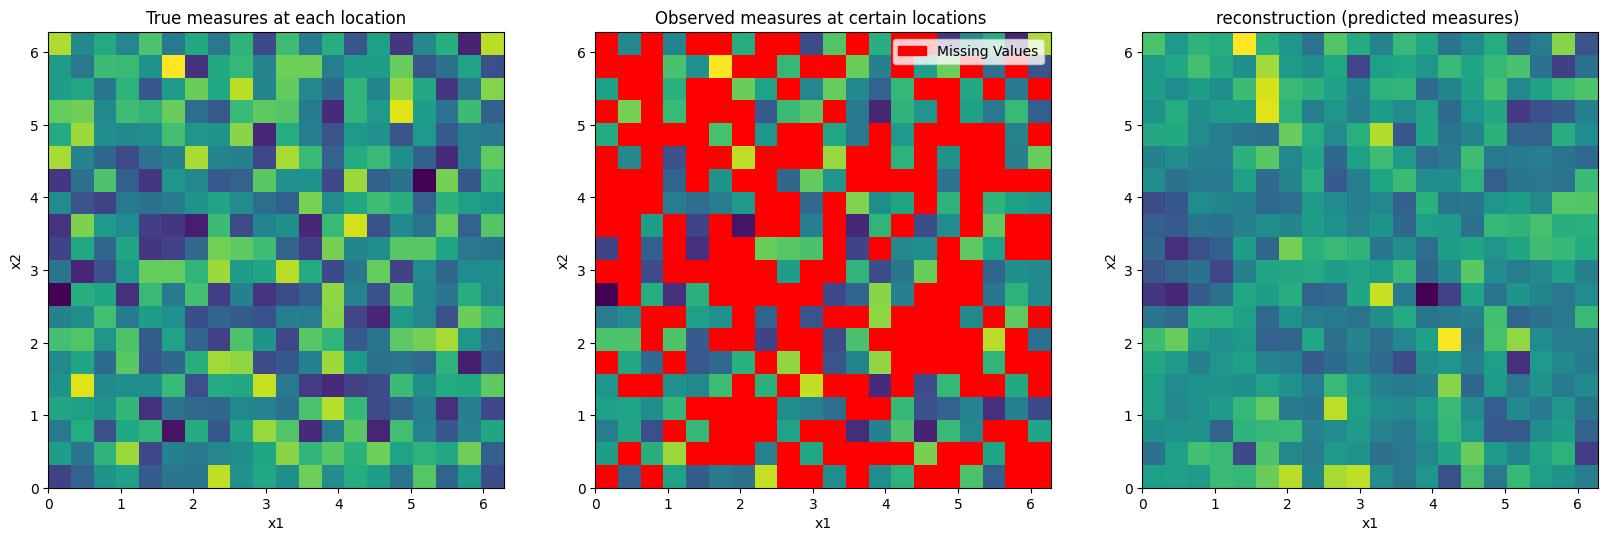

In [123]:

cmap = plt.cm.viridis
cmap.set_bad(color='red')

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

im1 = axes[0].imshow(Z, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
axes[0].set_title('True measures at each location')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

im2 = axes[1].imshow(Y, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap=cmap)
axes[1].set_title('Observed measures at certain locations ')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')


im2 = axes[2].imshow(predicted.numpy().reshape(-1,20), extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap=cmap)
axes[2].set_title('reconstruction (predicted measures) ')
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')

legend_handles = [mpatches.Patch(color='red', label='Missing Values')]
axes[1].legend(handles=legend_handles)

Text(0, 0.5, 'predicted measure at unobserved locations')

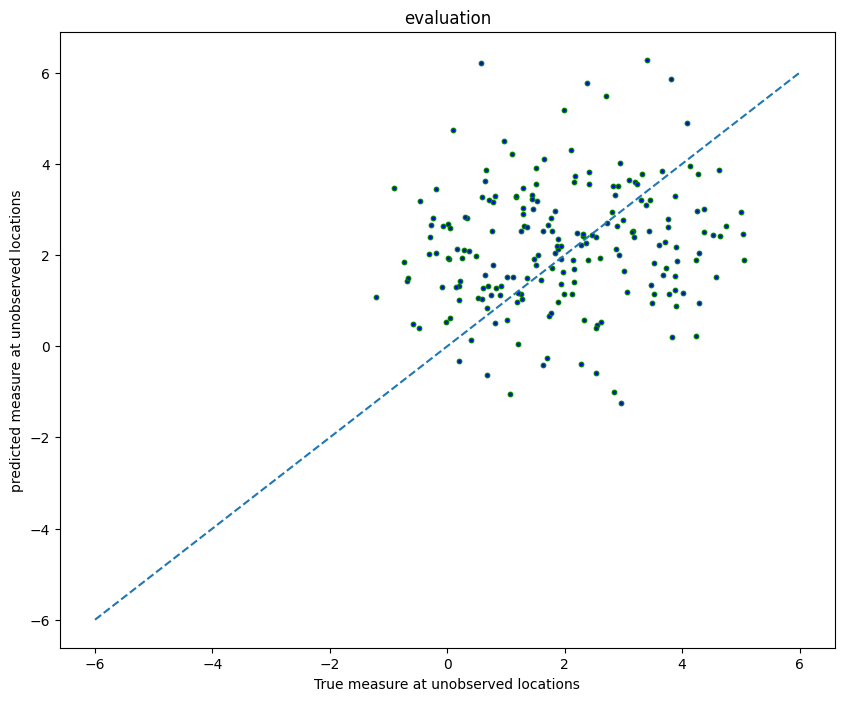

In [124]:
#@title Evaluation
fig, axes = plt.subplots(figsize=(10, 8))

axes.scatter(Y2[random_index], predicted[random_index], edgecolor='green',s=10, c='blue' )
axes.plot(np.linspace(-6,6,100),np.linspace(-6,6,100),linestyle='dashed')
axes.set_title('evaluation')
axes.set_xlabel('True measure at unobserved locations')
axes.set_ylabel('predicted measure at unobserved locations')


In [116]:
del hidden_net

# MCMC method


In [197]:
location=jnp.column_stack([A.ravel(),B.ravel()])
obs_loc_index=np.delete(jnp.arange(len(A.ravel())),random_index)
measure=jnp.array(y_obs)

print('measure val shape:', measure.shape)
print('')
print('shape unobserve locations index:',obs_loc_index.shape)

measure val shape: (200,)

shape unobserve locations index: (200,)


In [198]:
#@title define the radial basis kernel

def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - jitter (float): Small positive value added to the diagonal elements.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    return K

In [200]:
#@title Model
def model(x, obs_idx, y_obs=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5):

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    m = numpyro.sample("m", dist.MultivariateNormal(np.random.uniform(0, 4, n), covariance_matrix=K))

    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    numpyro.sample("y", dist.Normal(m[obs_idx], sigma), obs=y_obs)

In [201]:
#@title Inference
# fit the model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000, num_chains=4, chain_method='parallel', progress_bar=True)
start=time.time()
mcmc.run(jax.random.PRNGKey(42), location, obs_loc_index, measure )
end=time.time()
print('')
print('duration:', end-start )

# exatrct posterior
posterior_samples = mcmc.get_samples()
m_posterior = posterior_samples['m']

m_mean = jnp.mean(m_posterior, axis=0)
m_std = jnp.std(m_posterior, axis=0)

m_mean_2d = m_mean.reshape(A.shape)
m_std_2d  = m_std.reshape(B.shape)


<ipython-input-201-1c202d5662d3>:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000, num_chains=4, chain_method='parallel', progress_bar=True)
sample: 100%|██████████| 7000/7000 [01:30<00:00, 77.70it/s, 15 steps of size 2.96e-01. acc. prob=0.88]



duration: 362.20815086364746


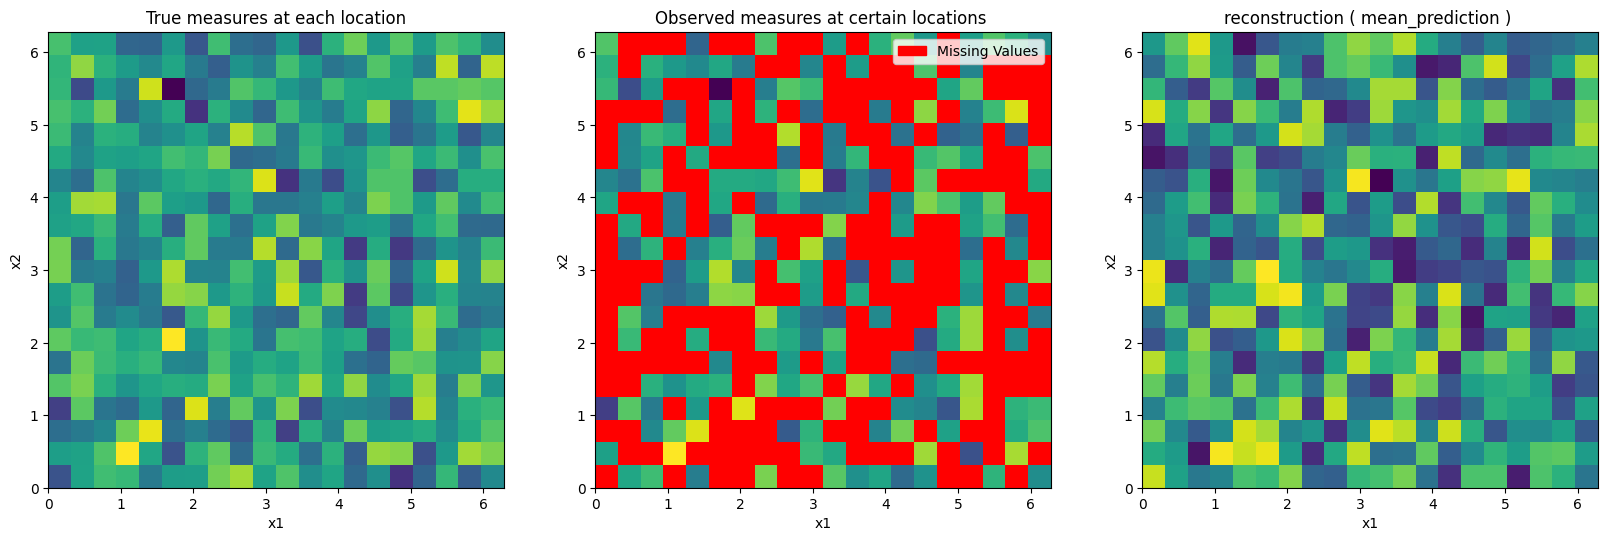

In [203]:
#@title visualisation
cmap = plt.cm.viridis
cmap.set_bad(color='red')

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

im1 = axes[0].imshow(Z, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
axes[0].set_title('True measures at each location')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

im2 = axes[1].imshow(Y, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap=cmap)
axes[1].set_title('Observed measures at certain locations ')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')


im3 = axes[2].imshow( m_mean_2d, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap=cmap)
axes[2].set_title('reconstruction ( mean_prediction ) ')
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')

legend_handles = [mpatches.Patch(color='red', label='Missing Values')]
axes[1].legend(handles=legend_handles)

<ipython-input-202-fd4390e9b85f>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print('WAIC metric value:',az.waic(data))
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC metric value: Computed from 20000 posterior samples and 200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -403.63     8.92
p_waic       51.09        -

There has been a warning during the calculation. Please check the results.

others metrics:


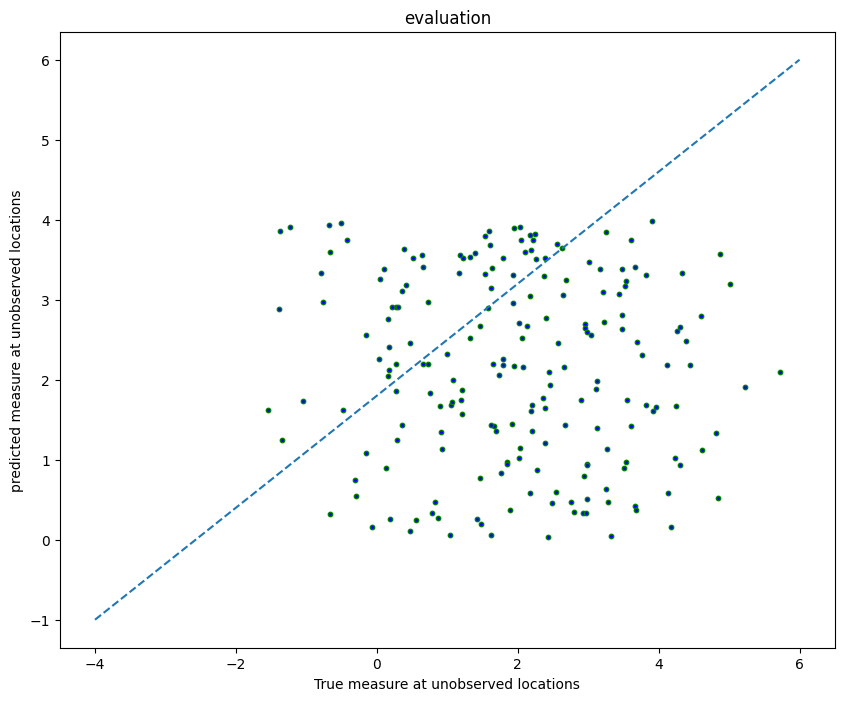

In [202]:
  #@title Evaluation
fig, axes = plt.subplots(figsize=(10, 8))

axes.scatter(Y2[random_index], m_mean_2d.ravel()[random_index], edgecolor='green',s=10, c='blue' )
axes.plot(np.linspace(-4,6,100),np.linspace(-1,6,100),linestyle='dashed')
axes.set_title('evaluation')
axes.set_xlabel('True measure at unobserved locations')
axes.set_ylabel('predicted measure at unobserved locations')

print('')

data = az.from_numpyro(mcmc)
print('WAIC metric value:',az.waic(data))
print('')
print('others metrics:',)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

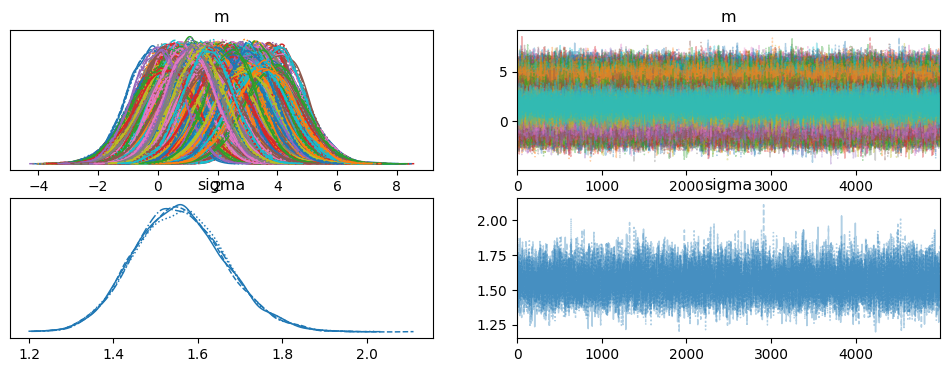

In [204]:
az.plot_trace(data, compact=True)


## summary

In [205]:
#@title predicted output from MCMC
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      m[0]      3.75      1.00      3.74      2.15      5.43  50916.02      1.00
      m[1]      2.27      0.84      2.27      0.91      3.67  54071.05      1.00
      m[2]      1.53      0.83      1.53      0.14      2.89  48295.41      1.00
      m[3]      1.74      1.01      1.74      0.13      3.46  46935.38      1.00
      m[4]      2.85      0.84      2.84      1.46      4.23  45492.54      1.00
      m[5]      2.70      0.99      2.71      1.01      4.28  51248.25      1.00
      m[6]      3.31      0.98      3.32      1.70      4.93  44048.11      1.00
      m[7]      1.20      0.84      1.20     -0.21      2.55  46957.73      1.00
      m[8]      1.12      1.00      1.13     -0.56      2.72  49598.26      1.00
      m[9]      2.67      1.00      2.67      1.05      4.31  52904.30      1.00
     m[10]      2.83      0.84      2.83      1.41      4.17  48401.88      1.00
     m[11]      3.20      0

In [209]:
#@title preticted output from NDE
print('samples:',predicted)

samples: tensor([ 3.6875,  3.8949,  1.9143,  5.0494,  3.8001,  1.2956,  1.3958,  4.7024,
         2.5050,  4.5169,  2.2175,  1.2654,  1.7575,  2.7188,  3.9832,  2.1065,
         0.8281,  0.6837,  2.8981,  1.2970,  2.3295,  2.1345,  0.1455,  3.8760,
         3.9154,  3.2239,  1.2853,  1.9410,  2.2515,  2.3109,  1.6869,  1.5494,
         1.8187,  2.8773,  3.6958,  2.0400,  1.4955,  0.4185,  1.5655,  1.9906,
         2.2888,  2.4577,  2.2969,  3.8342,  4.8302,  3.8041,  3.6109,  1.1586,
         1.5272,  1.7837,  0.8538, -0.4871,  1.9433,  3.3696,  1.4249,  1.1360,
         2.2513,  2.3551,  1.3304,  1.0040,  0.7439,  0.6147,  2.4995,  3.1412,
         2.2622,  3.4043,  0.8703,  1.4483,  1.7456,  2.0341,  1.3999,  1.0410,
         1.0933,  1.8615,  2.6545,  2.7733,  0.5572,  0.7234,  1.4409,  0.6405,
         2.4619,  1.7493,  1.8847,  2.5603,  2.3647,  1.4336,  1.1259,  3.4393,
         2.4381,  1.8697,  1.2410,  1.1762,  2.3251,  0.9733,  3.1376,  2.6514,
        -1.2791,  1.9927,  0.48

In [214]:
print('means of the conditional density (MoG):',mean)

means of the conditional density (MoG): tensor([[ 3.0504,  0.6262],
        [ 3.3084,  0.5819],
        [ 3.5367,  0.5332],
        [ 3.6278,  0.5044],
        [ 3.9570,  0.6857],
        [ 4.4196,  1.1760],
        [ 4.4686,  1.4436],
        [ 4.5189,  1.8822],
        [ 4.5038,  2.4228],
        [ 3.9342,  2.7071],
        [ 1.4090,  1.9535],
        [-0.7093,  1.2669],
        [-0.3077,  1.8692],
        [ 0.4960,  2.8448],
        [ 1.3287,  3.9303],
        [ 1.6851,  4.9547],
        [ 1.7497,  6.0651],
        [ 1.7018,  6.8513],
        [ 1.7385,  7.4127],
        [ 1.6795,  7.9162],
        [ 2.5939,  0.7023],
        [ 2.8216,  0.6067],
        [ 3.0775,  0.5649],
        [ 3.2958,  0.5177],
        [ 3.4070,  0.5418],
        [ 3.8575,  0.8999],
        [ 4.1005,  1.2685],
        [ 4.1777,  1.6376],
        [ 4.1768,  2.1963],
        [ 3.7131,  2.5203],
        [ 1.1820,  1.7674],
        [-0.6755,  1.2224],
        [-0.0760,  1.8749],
        [ 0.9331,  3.1405],
        

In [213]:
print('variances of the conditional density (MoG):',var)

variances of the conditional density (MoG): tensor([[2.0191, 4.2988],
        [1.7573, 4.4057],
        [1.5601, 4.4308],
        [1.4105, 4.3356],
        [1.6480, 4.3364],
        [1.8454, 4.2564],
        [1.6189, 3.8217],
        [1.3753, 3.4261],
        [1.1500, 3.0731],
        [1.1637, 2.9171],
        [1.8961, 3.4737],
        [2.6172, 3.9945],
        [2.5312, 4.1829],
        [1.5879, 3.8115],
        [0.8684, 3.2338],
        [0.6240, 2.3486],
        [0.7192, 1.7301],
        [0.9852, 1.5435],
        [1.1961, 1.5447],
        [1.3235, 1.4914],
        [2.1332, 3.6647],
        [1.8278, 3.8589],
        [1.5824, 3.9479],
        [1.3965, 3.9641],
        [1.3337, 3.8548],
        [1.6064, 3.8641],
        [1.5577, 3.5760],
        [1.3247, 3.1588],
        [1.0972, 2.8176],
        [1.0696, 2.5948],
        [1.7803, 3.1432],
        [2.3998, 3.6095],
        [2.1998, 3.7477],
        [1.0746, 3.1328],
        [0.6586, 2.5492],
        [0.6270, 1.6798],
        [0.8800, 1.4

In [130]:
#@title n
im4= axes[3].imshow( m_std_2d , extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap=cmap)
axes[3].set_title('std ( std_prediction ) ')
axes[3].set_xlabel('x1')
axes[3].set_ylabel('x2')


0.02